# 正規化と訓練・試験データ分割をする

In [1]:
#化合物処理の為の関数・クラス群
from RDKitWrapper import draw_SMILES,Fingerprint,RDKitDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# データベースの読み込み (data from wikipedia)

In [4]:
df=pd.read_csv("wiki.csv")

#今回は融点を予測してみる
df=df[["SMILES","Melting temperature"]]

#抜けデータの削除
df2=df.dropna()
df2

,SMILES,Melting temperature
0,N,-77.73
1,C#C,-80.8
2,O=P(O)(O)OP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n2c...,187
3,OC=1C(OC(=O)C=1O)[C@@H](O)CO,190/192
4,O[C@@H]3[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]3OC[C...,223
...,...,...
1363,C1=CSC(=C1)Br,-10
1364,C(CN(CC(=O)O)CC(=O)O)C(=O)O,190/200
1365,F[Nd](F)F,1374
1368,CCNC1=NC(=NC(=N1)Cl)NC(C)(C)C#N,168


In [6]:
#複数の融点がスラッシュ区切りで記録されているので、はじめのデータのみを使う

#まずはスラッシュで区切られたものを分割する
spl_y_df=df2["Melting temperature"].str.split("/", expand=True)

#1列目を代入
df2["Melting temperature"]=spl_y_df[0]
df2

C:\Users\kan\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,SMILES,Melting temperature
0,N,-77.73
1,C#C,-80.8
2,O=P(O)(O)OP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n2c...,187
3,OC=1C(OC(=O)C=1O)[C@@H](O)CO,190
4,O[C@@H]3[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]3OC[C...,223
...,...,...
1363,C1=CSC(=C1)Br,-10
1364,C(CN(CC(=O)O)CC(=O)O)C(=O)O,190
1365,F[Nd](F)F,1374
1368,CCNC1=NC(=NC(=N1)Cl)NC(C)(C)C#N,168


# Descriptorの計算

In [7]:
#クラスを使用する為の初期化処理
desc=RDKitDescriptors()

#smilesのリストをSMILES_listに代入
SMILES_list=df2["SMILES"].values

#記述子を計算。一部の化合物でエラーが出る。
desc_list=[desc.calc(i,dict_mode=False) for i in SMILES_list]

#エラーになった化合物では記述子の配列の代わりに-1が返るので、それをもとに選別フィルターを作成
available_filter=[(False if type(i)==type(1) else True) for i in desc_list]

failed to purse:  c1[nH]c2c(n1)c(=O)nc(n2)N
please recheck SMILES
invalid smiles! c1[nH]c2c(n1)c(=O)nc(n2)N
failed to purse:  O=[Cl]=O
please recheck SMILES
invalid smiles! O=[Cl]=O
failed to purse:  [Cd+2].[Cd+2].[Cd+2].[AsH6-3].[AsH6-3]
please recheck SMILES
invalid smiles! [Cd+2].[Cd+2].[Cd+2].[AsH6-3].[AsH6-3]
failed to purse:  [H]1[BH]2[H][BH]3[BH]24[BH]1[H][BH]4[H]3
please recheck SMILES
invalid smiles! [H]1[BH]2[H][BH]3[BH]24[BH]1[H][BH]4[H]3
failed to purse:  [O-2]=[Ce+4]=[O-2]
please recheck SMILES
invalid smiles! [O-2]=[Ce+4]=[O-2]
failed to purse:  B1([H]3)(C2CCCC1CCC2)[H]B34C2CCCC4CCC2
please recheck SMILES
invalid smiles! B1([H]3)(C2CCCC1CCC2)[H]B34C2CCCC4CCC2
failed to purse:  FCl(F)(F)(F)F
please recheck SMILES
invalid smiles! FCl(F)(F)(F)F
failed to purse:  FBr(F)(F)(F)F
please recheck SMILES
invalid smiles! FBr(F)(F)(F)F
failed to purse:  o=c([o-])C.[N+H4]
please recheck SMILES
invalid smiles! o=c([o-])C.[N+H4]
failed to purse:  c1=cc=c[cH+]c=c1
please recheck SMILES
i

In [9]:
#エラーになっていないidのデータのみ残す
df3=df2[available_filter]

#yの設定
y=df3["Melting temperature"].values

#文字列になっているので、floatに変換
Y=np.array(y,dtype=np.float)

#scikit-learnでは、yは下記の形に変換しないと計算ができない(おまじない)
Y=Y.reshape(-1,1)
Y

array([[ -77.73],
       [ -80.8 ],
       [ 187.  ],
       ...,
       [1374.  ],
       [ 168.  ],
       [ 155.  ]])

In [10]:
#計算に失敗した記述子は削除する
X=[x for x in desc_list if type(x)!=type(1)]

#numpyに変換
X=np.array(X)


In [11]:
print(X.shape)
print(Y.shape)

(1047, 200)
(1047, 1)


# 機械学習の為の前処理

In [30]:
#融点はrangeが広いので、ケルビンスケールに変更後、logにしてしまう (ノウハウ)
log_Y=np.log10(Y+273.15)
log_Y

array([[2.29096901],
       [2.28409219],
       [2.66289943],
       ...,
       [3.21673315],
       [2.64458628],
       [2.63159595]])

In [36]:
from sklearn.model_selection import train_test_split

#10%をランダムに選んでテストデータにする。 小規模データの場合は  cross validationした方が良いが、今回は割愛
X_train, X_test, Y_train, Y_test = train_test_split(X, log_Y,test_size=0.1)

In [37]:
#平均がゼロ、標準偏差が1になるように正規化する
from sklearn.preprocessing import StandardScaler


#X
X_scaler=StandardScaler()

scaled_X_train=X_scaler.fit_transform(X_train)
scaled_X_test=X_scaler.transform(X_test)

#Y
Y_scaler=StandardScaler()

scaled_Y_train=Y_scaler.fit_transform(Y_train)
scaled_Y_test=Y_scaler.transform(Y_test)

# 機械学習

In [43]:
#プロット用のutility
from sklearn.metrics import r2_score
def auto_analysis(tr_X,tr_Y,te_X,te_Y,model):
    model.fit(tr_X,tr_Y)
    
    pred_tr_Y=model.predict(tr_X)
    pred_te_Y=model.predict(te_X)
    
    plt.scatter(tr_Y,pred_tr_Y)
    plt.scatter(te_Y,pred_te_Y)
    
    tr_r2=r2_score(tr_Y,pred_tr_Y)
    te_r2=r2_score(te_Y,pred_te_Y)
    
    print("train score: ",tr_r2)
    print("test score: ",te_r2)
    
    
    return model
    

train score:  0.6365240301278097
test score:  -2.601908268921741e+24


,0,1
0,0.185006,MaxEStateIndex
1,-0.00836682,MinEStateIndex
2,0.042422,MaxAbsEStateIndex
3,-0.0521943,MinAbsEStateIndex
4,0.120541,qed
...,...,...
195,0.121218,fr_thiazole
196,-0.050809,fr_thiocyan
197,-0.0159404,fr_thiophene
198,0.0559045,fr_unbrch_alkane


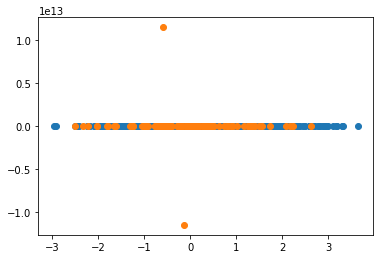

In [44]:
#線形回帰
from sklearn.linear_model import LinearRegression


model=LinearRegression()

model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)

#係数を解析
import_param_df=pd.DataFrame((model.coef_[0],desc.desc_list)).T
import_param_df

C:\Users\kan\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


train score:  0.9567339750805046
test score:  0.7584200534838339


,0,1
0,0.00273598,MaxEStateIndex
1,0.00850385,MinEStateIndex
2,0.00297338,MaxAbsEStateIndex
3,0.00669753,MinAbsEStateIndex
4,0.0106371,qed
...,...,...
195,0,fr_thiazole
196,2.41337e-06,fr_thiocyan
197,2.31772e-06,fr_thiophene
198,0.000197625,fr_unbrch_alkane


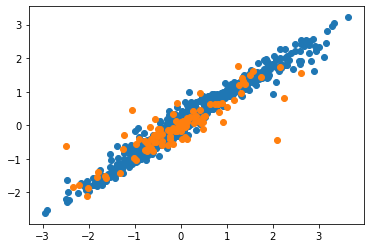

In [45]:
#random forest
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor()
model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)

#パラメータの重要度を解析
import_param_df=pd.DataFrame((model.feature_importances_,desc.desc_list)).T
import_param_df

train score:  0.5137792884685106
test score:  0.41244026514707033


,0,1
0,0.0679112,MaxEStateIndex
1,0,MinEStateIndex
2,0,MaxAbsEStateIndex
3,-0.0903822,MinAbsEStateIndex
4,0.109868,qed
...,...,...
195,0.0463377,fr_thiazole
196,-0.0358186,fr_thiocyan
197,0,fr_thiophene
198,0,fr_unbrch_alkane


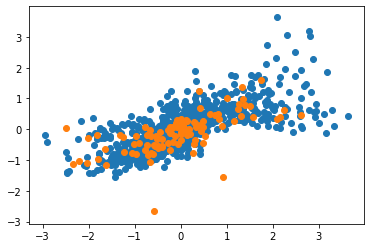

In [49]:
#lasso
from sklearn.linear_model import Lasso

model=Lasso(alpha=0.01)
model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)

#係数を解析
import_param_df=pd.DataFrame((model.coef_,desc.desc_list)).T
import_param_df

train score:  1.0
test score:  0.12961106267881595


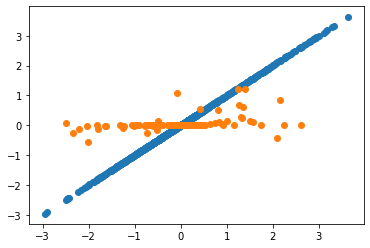

In [52]:
#gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor

model=GaussianProcessRegressor()
model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)



In [53]:
#信頼区間の表示
model.predict(scaled_X_train,return_std=True)

(array([[ 5.15807247e-01],
        [-5.47303760e-01],
        [ 7.14431993e-01],
        [ 2.26782848e-01],
        [ 1.16139481e+00],
        [ 6.56471220e-02],
        [ 9.58706420e-01],
        [-2.88483703e-01],
        [-3.81277340e-01],
        [-8.19917436e-03],
        [ 4.57091398e-01],
        [ 4.82282998e-01],
        [ 3.00595916e+00],
        [ 5.36876570e-01],
        [-5.82151107e-01],
        [ 3.36997856e-01],
        [ 6.15408786e-01],
        [-1.50787089e+00],
        [-1.50423502e-01],
        [-3.29572761e-01],
        [-1.29893668e-01],
        [ 4.54267560e-01],
        [-4.79817609e-01],
        [-7.38656293e-01],
        [-9.41864830e-01],
        [-3.97121988e-01],
        [-6.34494807e-01],
        [-1.29067530e+00],
        [-5.81044523e-02],
        [-5.84863541e-01],
        [ 2.16830891e+00],
        [-9.92956853e-01],
        [-8.12088005e-01],
        [-1.38073853e-01],
        [-1.40463273e+00],
        [ 2.03794910e+00],
        [-5.57944990e-01],
 

C:\Users\kan\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train score:  0.9314060195319289
test score:  0.563095371205177


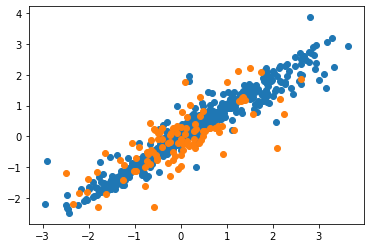

In [55]:
#neural net
from sklearn.neural_network import MLPRegressor

model=MLPRegressor()
model=auto_analysis(scaled_X_train,scaled_Y_train,scaled_X_test,scaled_Y_test,model)
